In [170]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import random
from scipy import stats as sts
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [171]:
data_main = pd.read_csv('/Users/jdobrow/Desktop/google-play-store-apps/googleplaystore.csv')
data_main.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [172]:
# PART 1: DATA CLEANING
# We are missing a bunch of Ratings, 1 'Type', 1 'Content Rating', and some versions.
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [173]:
data_main.columns = ['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'ContentRating', 'Genres', 'LastUpdated', 'CurrentVer', 'AndroidVer']

In [174]:
# 1. "App" first I want to see if each element is unique. Apparently there are some repeats.
print(data_main.App.nunique())
print(len(data_main.App))

9660
10841


In [175]:
app_array = []
repeat_array = []
for i in range(len(data_main.App)):
    if data_main.App[i] not in app_array:
        app_array.append(data_main.App[i])
    else:
        repeat_array.append((data_main.App[i],i))

In [176]:
data_main[data_main.App == 'Google My Business']
# After running some exploration, it appears that there's just a bunch of identical rows.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,ContentRating,Genres,LastUpdated,CurrentVer,AndroidVer
193,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
239,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
268,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up


In [177]:
data_main_clean = data_main.drop([x[1] for x in repeat_array])
data_main_clean.reset_index(drop=True, inplace=True)

In [178]:
# 2. Category. Looks fine.
data_main_clean.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [179]:
# 3. Rating. First we need to address Missing values. Since this is a likely outcome 
# for machine learning I will drop those rows
drop_rows_list_rating = []
for row_index in range(len(data_main_clean)):
    if (data_main_clean.Rating[row_index] != data_main_clean.Rating[row_index]) or data_main_clean.Rating[row_index] > 5:
        drop_rows_list_rating.append(row_index)
data_main_clean = data_main_clean.drop(drop_rows_list_rating)
data_main_clean.reset_index(drop=True, inplace=True)

In [180]:
# 4. Reviews. I want this as a number, not a string. There's one pesky '3.0M' in there that I manually
# replaced with 3000000
review_list = []
for i in range(len(data_main_clean.Reviews)):
    try:
        review_list.append(int(data_main_clean.Reviews[i]))
    except:
        review_list.append(3000000)
data_main_clean['Reviews'] = review_list

In [181]:
len(data_main_clean[data_main_clean.Size == 'Varies with device'])

1169

In [182]:
# 5. Size. There are 1169 rows where the size 'Varies with device.'
# I'm going to set them to the median since I can't afford to drop another 1000 rows.
size_list = []
for i in range(len(data_main_clean)):
    if data_main_clean.Size[i] != 'Varies with device':
        size_list.append(data_main_clean.Size[i][:-1])
    else:
        size_list.append('-1')
for i in range(len(size_list)):
    size_list[i] = size_list[i].replace(',','')
    size_list[i] = int(float(size_list[i])*1000000)
med_size_list = []
for size in size_list:
    if size > 0:
        med_size_list.append(size)
med_size = stats.median(med_size_list)
for sizeindex in range(len(size_list)):
    if size_list[sizeindex] < 0:
        size_list[sizeindex] = med_size
data_main_clean.Size = size_list

In [183]:
# 6. Installs. This is actually a categorical variable.
install_list = []
for i in range(len(data_main_clean.Installs)):
    x = data_main_clean.Installs[i][:-1]
    x = x.replace(',','')
    x = int(x)
    install_list.append(x)
data_main_clean.Installs = install_list

In [184]:
# 7. Type is all good. 8. Price: Converted to cents
price_list = []
for i in range(len(data_main_clean.Price)):
    if data_main_clean.Price[i] == '0':
        price_list.append(0.0)
    else:
        price_list.append(float(data_main_clean.Price[i][1:]))
for i in range(len(price_list)):
    price_list[i] *= 100
data_main_clean.Price = price_list
# 9. Content Rating, 10. Genres, 11. Last Updated Look fine also. 
#12. Not exactly sure what version means or what to do with it for now.

In [185]:
data_main_clean.Price.unique()

array([    0.,   499.,   399.,   699.,   799.,   599.,   299.,   349.,
         199.,   999.,   749.,    99.,   900.,   549.,  1000.,  2499.,
        1199.,  7999.,  1699.,  1499.,  2999.,  1299.,   249.,  1099.,
         150.,  1999.,  1599.,  3399.,  3999.,   395.,   449.,   170.,
         899.,   149.,   388., 39999.,  1799., 40000.,   302.,   176.,
         484.,   477.,   161.,   250.,   159.,   649.,   129., 29999.,
       37999.,  3799.,  1899., 38999.,   849.,   175.,  1400.,   200.,
         308.,   259.,  1940.,   390.,   459.,  1546.,   304.,  1399.,
         429.,   328.,   460.,   100.,   295.,   290.,   197.,   256.,
         120.])

In [186]:
# There is a data cluster around very highly priced apps that I want to explore
# I decided after some googling that all of these high-priced rows are from 'Trolls' and should be removed
explore_data_1 = data_main_clean[data_main_clean.Price > 100]
data_main_clean = data_main_clean[data_main_clean.Price < 10000]
data_main_clean.reset_index(drop=True, inplace=True)
explore_data_1

,App,Category,Rating,Reviews,Size,Installs,Type,Price,ContentRating,Genres,LastUpdated,CurrentVer,AndroidVer
222,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6800000,100000,Paid,499.0,Everyone,Business,"March 25, 2018",1.5.2,4.0 and up
223,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39000000,100000,Paid,499.0,Everyone,Business,"April 11, 2017",3.4.6,3.0 and up
360,Puffin Browser Pro,COMMUNICATION,4.0,18247,15000000,100000,Paid,399.0,Everyone,Communication,"July 5, 2018",7.5.3.20547,4.1 and up
394,"Moco+ - Chat, Meet People",DATING,4.2,1545,15000000,10000,Paid,399.0,Mature 17+,Dating,"June 19, 2018",2.6.139,4.1 and up
395,Calculator,DATING,2.6,57,6200000,1000,Paid,699.0,Everyone,Dating,"October 25, 2017",1.1.6,4.0 and up
396,AMBW Dating App: Asian Men Black Women Interra...,DATING,3.5,2,17000000,100,Paid,799.0,Mature 17+,Dating,"January 21, 2017",1.0.1,4.0 and up
637,Sago Mini Hat Maker,EDUCATION,4.9,11,63000000,1000,Paid,399.0,Everyone,Education;Pretend Play,"July 24, 2017",1.0,4.0.3 and up
638,Fuzzy Numbers: Pre-K Number Foundation,EDUCATION,4.7,21,44000000,1000,Paid,599.0,Everyone,Education;Education,"July 21, 2017",1.3,4.1 and up
639,Toca Life: City,EDUCATION,4.7,31085,24000000,500000,Paid,399.0,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up
640,Toca Life: Hospital,EDUCATION,4.7,3528,24000000,100000,Paid,399.0,Everyone,Education;Pretend Play,"June 12, 2018",1.1.1-play,4.4 and up


In [187]:
# Now our data is clean(er)! Lets look:
data_main_clean.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,ContentRating,Genres,LastUpdated,CurrentVer,AndroidVer
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [188]:
# PART 2: FEATURE ENGINEERING

In [189]:
# 1. App: Design and simplicity matters! I want to engineer a new column that is # words in the title
title_length = []
for i in range(len(data_main_clean.App)):
    x = data_main_clean.App[i].split()
    title_length.append(len(x))
data_main_clean['TitleNumberWords'] = title_length
is_one_word = []
for words in title_length:
    if words == 1:
        is_one_word.append(1)
    else:
        is_one_word.append(0)
data_main_clean['IsOneWordTitle'] = is_one_word
is_long_title = []
for words in title_length:
    if words > 6:
        is_long_title.append(1)
    else:
        is_long_title.append(0)
data_main_clean['IsLongTitle'] = is_long_title

In [190]:
# 2. Category. I don't want to go here yet.

In [191]:
# 3. Rating.
bad_ratings = []
for rating in data_main_clean.Rating:
    if rating < 4:
        bad_ratings.append(1)
    else:
        bad_ratings.append(0)
data_main_clean['IsBadRating'] = bad_ratings
great_ratings = []
for rating in data_main_clean.Rating:
    if rating > 4.5:
        great_ratings.append(1)
    else:
        great_ratings.append(0)
data_main_clean['IsGreatRating'] = great_ratings

In [192]:
# 4. Reviews
log_reviews = []
for row in data_main_clean.Reviews:
    log_reviews.append(math.log(row))
data_main_clean['LogReviews'] = log_reviews
is_few_reviews = []
for row in data_main_clean.Reviews:
    if row < 1000:
        is_few_reviews.append(1)
    else:
        is_few_reviews.append(0)
data_main_clean['IsFewReviews'] = is_few_reviews
is_many_reviews = []
for row in data_main_clean.Reviews:
    if row > 500000:
        is_many_reviews.append(1)
    else:
        is_many_reviews.append(0)
data_main_clean['IsManyReviews'] = is_many_reviews

In [193]:
# 5. Size
log_size = []
is_large_size = []
is_small_size = []
for row in data_main_clean.Size:
    if row > 1:
        log_size.append(math.log(row))
    if row > 50000000:
        is_large_size.append(1)
    else:
        is_large_size.append(0)
    if (row < 5000000):
        is_small_size.append(1)
    else:
        is_small_size.append(0)
data_main_clean['LogSize'] = log_size
data_main_clean['IsLargeSize'] = is_large_size
data_main_clean['IsSmallSize'] = is_small_size

In [194]:
data_main_clean.Installs.unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,        100,        500,
               10,          5,         50,          1])

In [195]:
# 6. Installs
randomized_installs = []
for row in data_main_clean.Installs:
    if row == 1000000000:
        randomized_installs.append(random.randint(1000000000,5000000000 - 1))
    if row == 500000000:
        randomized_installs.append(random.randint(500000000,1000000000 - 1))
    if row == 100000000:
        randomized_installs.append(random.randint(100000000,500000000 - 1))
    if row == 50000000:
        randomized_installs.append(random.randint(50000000,100000000 - 1))
    if row == 10000000:
        randomized_installs.append(random.randint(10000000,50000000 - 1))
    if row == 5000000:
        randomized_installs.append(random.randint(5000000,10000000 - 1))
    if row == 1000000:
        randomized_installs.append(random.randint(1000000,5000000 - 1))
    if row == 500000:
        randomized_installs.append(random.randint(500000,1000000 - 1))
    if row == 100000:
        randomized_installs.append(random.randint(100000,500000 - 1))
    if row == 50000:
        randomized_installs.append(random.randint(50000,100000 - 1))
    if row == 10000:
        randomized_installs.append(random.randint(10000,50000 - 1))
    if row == 5000:
        randomized_installs.append(random.randint(5000,10000 - 1))
    if row == 1000:
        randomized_installs.append(random.randint(1000,5000 - 1))
    if row == 500:
        randomized_installs.append(random.randint(500,1000 - 1))
    if row == 100:
        randomized_installs.append(random.randint(100,500 - 1))
    if row == 50:
        randomized_installs.append(random.randint(50,100 - 1))
    if row == 10:
        randomized_installs.append(random.randint(10,50 - 1))
    if row == 5:
        randomized_installs.append(random.randint(5,10 - 1))
    if row == 1:
        randomized_installs.append(random.randint(1,5 - 1))
data_main_clean['RandomInstalls'] = randomized_installs

log_random_installs = []
for row in data_main_clean.RandomInstalls:
    log_random_installs.append(math.log(row))
data_main_clean['LogRandomInstalls'] = log_random_installs

log_installs = []
for row in data_main_clean.Installs:
    log_installs.append(math.log(row))
data_main_clean['LogInstalls'] = log_installs

is_few_installs = []
for row in data_main_clean.Installs:
    if row < 2000:
        is_few_installs.append(1)
    else:
        is_few_installs.append(0)
data_main_clean['IsFewInstalls'] = is_few_installs

is_many_installs = []
for row in data_main_clean.Installs:
    if row > 1000000:
        is_many_installs.append(1)
    else:
        is_many_installs.append(0)
data_main_clean['IsManyInstalls'] = is_many_installs

condensed_install_list = []
for i in range(len(data_main_clean.Installs)):
    if data_main_clean.Installs[i] < 5001:
        condensed_install_list.append('Low')
    elif data_main_clean.Installs[i] < 1000001:
        condensed_install_list.append('Mid')
    else:
        condensed_install_list.append('High')
data_main_clean['CondensedInstalls'] = condensed_install_list

In [196]:
# Content Rating. I decided to combine a few categories into one and make a new column
content_list = []
for rating in data_main_clean.ContentRating:
    if rating == 'Mature 17+':
        content_list.append('Mature')
    elif rating == 'Adults only 18+':
        content_list.append('Mature')
    elif rating == 'Unrated':
        content_list.append('Everyone 10+')
        # There was only 1 unrated app and it appears to be suitable for everyone 10+
    else:
        content_list.append(rating)
data_main_clean['CondensedContentRating'] = content_list

In [197]:
#11. Last updated: I want to split this into two columns, one for month and one for year
month_list = []
for i in data_main_clean.LastUpdated:
    if 'January' in i:
        month_list.append(1)
    elif 'February' in i:
        month_list.append(2)
    elif 'March' in i:
        month_list.append(3)
    elif 'April' in i:
        month_list.append(4)
    elif 'May' in i:
        month_list.append(5)
    elif 'June' in i:
        month_list.append(6)
    elif 'July' in i:
        month_list.append(7)
    elif 'August' in i:
        month_list.append(8)
    elif 'September' in i:
        month_list.append(9)
    elif 'October' in i:
        month_list.append(10)
    elif 'November' in i:
        month_list.append(11)
    elif 'December' in i:
        month_list.append(12)
    else:
        print(i)
data_main_clean['LastUpdatedMonth'] = month_list

year_list = []
for i in range(len(data_main_clean.LastUpdated)):
    year_list.append(int(data_main_clean.LastUpdated[i][-4:]))
data_main_clean['LastUpdatedYear'] = year_list

recent_update_list = []
for i in range(len(data_main_clean)):
    if (data_main_clean.LastUpdatedMonth[i] == 8) and (data_main_clean.LastUpdatedYear[i] == 2018):
        recent_update_list.append(1)
    else:
        recent_update_list.append(0)
data_main_clean['IsRecentUpdate'] = recent_update_list

old_app_list = []
for year in data_main_clean.LastUpdatedYear:
    if year < 2017:
        old_app_list.append(1)
    else:
        old_app_list.append(0)
data_main_clean['IsStagnantUpdated'] = old_app_list

months_ago = []
for i in range(len(data_main_clean.LastUpdated)):
    time = 0
    time = time + 12*(2018 - data_main_clean.LastUpdatedYear[i])
    time = time + (8 - data_main_clean.LastUpdatedMonth[i])
    months_ago.append(time)
data_main_clean['UpdatedMonthsAgo'] = months_ago

log_months_ago = []
for i in data_main_clean.UpdatedMonthsAgo:
    log_months_ago.append(math.log(i + 1))
data_main_clean['LogUpdatedMonthsAgo'] = log_months_ago

In [198]:
review_per_install = []
for i in range(len(data_main_clean)):
    review_per_install.append(data_main_clean.Reviews[i]/data_main_clean.Installs[i])
data_main_clean['ReviewsPerInstall'] = review_per_install

In [199]:
exponential_rating = []
for rating in data_main_clean.Rating:
    exponential_rating.append(2.718**rating)
data_main_clean['ExponentialRating'] = exponential_rating

In [200]:
prices = []
for i in data_main_clean.Price:
    if i>0:
        prices.append(math.log(i)**.1)
    else:
        prices.append(0)
data_main_clean['LogPrice'] = prices

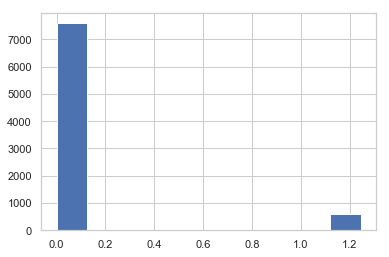

In [201]:
plt.hist(prices)
plt.show()

In [202]:
title_words = []
for i in data_main_clean.TitleNumberWords:
    title_words.append(math.log(i))
data_main_clean['LogTitleNumberWords'] = title_words

In [203]:
condensed_category = []
for i in data_main_clean.Category:
    if (i == 'PRODUCTIVITY') or (i == 'TOOLS') or (i == 'FINANCE') or (i == 'BUSINESS') or (i == "SHOPPING"):
        condensed_category.append('BUSINESS')
    elif (i == 'COMMUNICATION') or (i == 'SOCIAL') or (i == 'DATING') or (i == 'FOOD_AND_DRINK') or (i == 'BEAUTY'):
        condensed_category.append('SOCIAL')
    elif (i == 'ENTERTAINMENT') or (i == 'GAME') or (i == 'SPORTS') or (i == 'COMICS'):
        condensed_category.append('ENTERTAINMENT')
    elif (i == 'EDUCATION') or (i == 'FAMILY') or (i == 'NEWS_AND_MAGAZINES') or (i =='PARENTING') or (i == 'BOOKS_AND_REFERENCE') or (i == 'HOUSE_AND_HOME') or (i == "LIBRARIES_AND_DEMO"):
        condensed_category.append('FAMILY')
    elif (i == 'HEALTH_AND_FITNESS') or (i == 'MEDICAL') or (i == 'LIFESTYLE'):
        condensed_category.append('MEDICAL')
    elif (i == 'TRAVEL_AND_LOCAL') or (i == 'MAPS_AND_NAVIGATION') or (i == 'AUTO_AND_VEHICLES') or (i == 'EVENTS') or (i == 'WEATHER'):
        condensed_category.append('MAPS_AND_NAVIGATION')
    elif (i == 'ART_AND_DESIGN') or (i == 'PERSONALIZATION') or (i == 'PHOTOGRAPHY') or (i =='VIDEO_PLAYERS'):
        condensed_category.append('ART_AND_DESIGN')
    else:
        print(i)
data_main_clean['CondensedCategory'] = condensed_category

In [204]:
reviews_ranges = pd.qcut(data_main_clean.Reviews, 9).unique()
condensed_reviews = []
for i in data_main_clean.Reviews:
    if i in reviews_ranges[0]:
        condensed_reviews.append(1)
    elif i in reviews_ranges[1]:
        condensed_reviews.append(2)
    elif i in reviews_ranges[2]:
        condensed_reviews.append(3)
    elif i in reviews_ranges[3]:
        condensed_reviews.append(4)
    elif i in reviews_ranges[4]:
        condensed_reviews.append(5)
    elif i in reviews_ranges[5]:
        condensed_reviews.append(6)
    elif i in reviews_ranges[6]:
        condensed_reviews.append(7)
    elif i in reviews_ranges[7]:
        condensed_reviews.append(8)
    elif i in reviews_ranges[8]:
        condensed_reviews.append(9)
    else:
        print(i)
data_main_clean['CondensedReviews'] = condensed_reviews

In [205]:
reviews_ranges = pd.cut(data_main_clean.UpdatedMonthsAgo, 9).unique()
condensed_reviews = []
for i in data_main_clean.UpdatedMonthsAgo:
    if i in reviews_ranges[0]:
        condensed_reviews.append(1)
    elif i in reviews_ranges[1]:
        condensed_reviews.append(2)
    elif i in reviews_ranges[2]:
        condensed_reviews.append(3)
    elif i in reviews_ranges[3]:
        condensed_reviews.append(4)
    elif i in reviews_ranges[4]:
        condensed_reviews.append(5)
    elif i in reviews_ranges[5]:
        condensed_reviews.append(6)
    elif i in reviews_ranges[6]:
        condensed_reviews.append(7)
    elif i in reviews_ranges[7]:
        condensed_reviews.append(8)
    elif i in reviews_ranges[8]:
        condensed_reviews.append(9)
    else:
        print(i)
data_main_clean['CondensedUpdatedMonthsAgo'] = condensed_reviews

In [206]:
data_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 44 columns):
App                          8181 non-null object
Category                     8181 non-null object
Rating                       8181 non-null float64
Reviews                      8181 non-null int64
Size                         8181 non-null int64
Installs                     8181 non-null int64
Type                         8181 non-null object
Price                        8181 non-null float64
ContentRating                8181 non-null object
Genres                       8181 non-null object
LastUpdated                  8181 non-null object
CurrentVer                   8177 non-null object
AndroidVer                   8179 non-null object
TitleNumberWords             8181 non-null int64
IsOneWordTitle               8181 non-null int64
IsLongTitle                  8181 non-null int64
IsBadRating                  8181 non-null int64
IsGreatRating                8181 non-null int64

In [207]:
# PART 3: VISUALIZATION
sns.set(style="whitegrid")

In [208]:
priced_data = data_main_clean[data_main_clean.Price > 0]

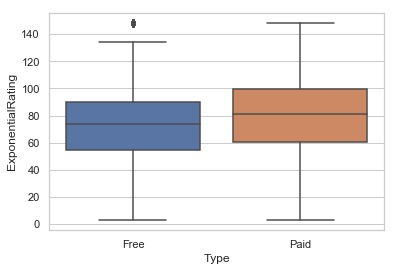

In [209]:
ax = sns.boxplot(y='ExponentialRating', x='Type', data=data_main_clean)

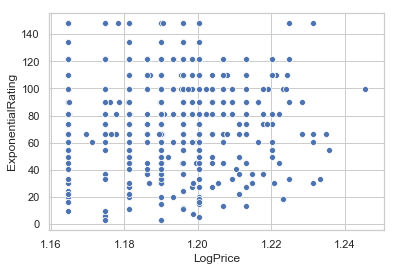

In [210]:
# How Does Price Influence Rating?
g = sns.scatterplot(x = 'LogPrice', y = 'ExponentialRating', data=priced_data)

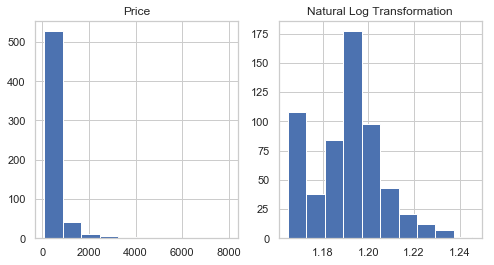

In [211]:
f, axes = plt.subplots(1,2, sharey=False, figsize=(8,4))
axes[0].hist(priced_data.Price)
axes[0].set_title('Price')
axes[1].hist(priced_data.LogPrice)
axes[1].set_title('Natural Log Transformation')
plt.show()

In [212]:
corr = priced_data.loc[:,['LogTitleNumberWords', 'LogReviews', 'LogSize', 'LogInstalls', 'ExponentialRating', 'LogPrice']][data_main_clean.Price > 0].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,LogTitleNumberWords,LogReviews,LogSize,LogInstalls,ExponentialRating,LogPrice
LogTitleNumberWords,1,-0.023,0.013,-0.0187,0.0168,-0.0583
LogReviews,-0.023,1,0.11,0.939,0.0869,0.1
LogSize,0.013,0.11,1,0.132,0.00701,-0.0215
LogInstalls,-0.0187,0.939,0.132,1,-0.00988,0.0973
ExponentialRating,0.0168,0.0869,0.00701,-0.00988,1,-0.0746
LogPrice,-0.0583,0.1,-0.0215,0.0973,-0.0746,1


/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1 :	  nan
10 :	  -0.14233214123262103
50 :	  -0.28710290489394796
100 :	  -0.3182306309077638
500 :	  0.10072992826680686
1000 :	  -0.027655056574143036
5000 :	  -0.2504200898282462
10000 :	  0.14732841046873427
50000 :	  -0.010735808123858541
100000 :	  -0.07298466865503511
500000 :	  0.09521268782867501
1000000 :	  0.277682401770789
10000000 :	  -1.0


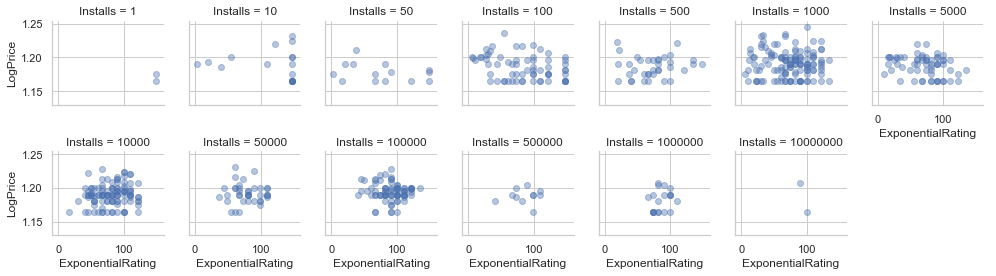

In [213]:
# Looks Random. Highest correlation is -.32 at Installs == 100.
g = sns.FacetGrid(priced_data, col='Installs', col_wrap=7, height=2)
g = g.map(plt.scatter, 'ExponentialRating', 'LogPrice', alpha = .4)
for install in sorted(priced_data.Installs.unique()):
    print(install, ':\t ', np.corrcoef(priced_data.ExponentialRating[priced_data.Installs == install], priced_data.LogPrice[priced_data.Installs == install])[0][1])

Everyone :	  -0.0865276009311111
Everyone 10+ :	  0.17405786029671583
Mature 17+ :	  -0.07352456904036668
Teen :	  -0.2098985181881704


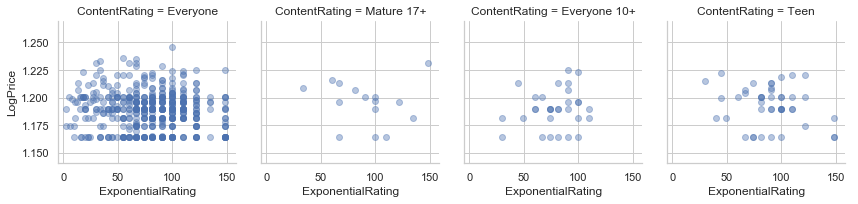

In [214]:
# Looks Random. Highest correlation is -.2 at Teen Rated Apps.
g = sns.FacetGrid(priced_data, col='ContentRating', col_wrap=4, height=3)
g = g.map(plt.scatter, 'ExponentialRating', 'LogPrice', alpha = .4)
for rating in sorted(priced_data.ContentRating.unique()):
    print(rating, ':\t ', np.corrcoef(priced_data.ExponentialRating[priced_data.ContentRating == rating], priced_data.LogPrice[priced_data.ContentRating == rating])[0][1])

1 :	  -0.36744280328447304
2 :	  -0.2455770525075093
3 :	  -0.053616466538739735
4 :	  0.015066241951601455
5 :	  -0.04572781064591855
6 :	  0.1804484421201929
7 :	  0.24365724455140858
8 :	  0.05889708590801535
9 :	  -0.0396148189020406
10 :	  -0.986170084487105
11 :	  nan


/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


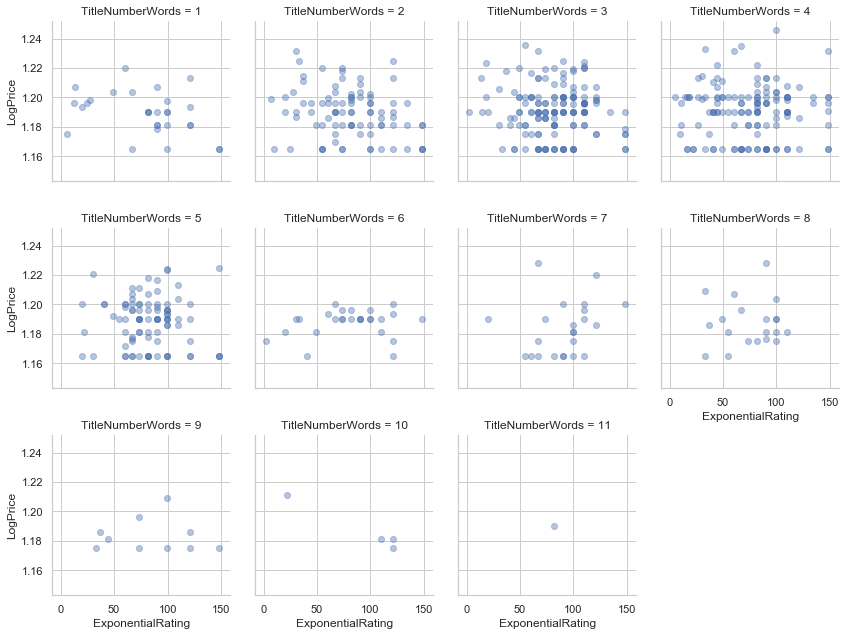

In [215]:
# Split up by number of words in the title. Highest Correlation is when the title is 1 word at -.36
g = sns.FacetGrid(priced_data, col='TitleNumberWords', col_wrap=4, height=3)
g = g.map(plt.scatter, 'ExponentialRating', 'LogPrice', alpha = .4)
for rating in sorted(priced_data.TitleNumberWords.unique()):
    print(rating, ':\t ', np.corrcoef(priced_data.ExponentialRating[priced_data.TitleNumberWords == rating], priced_data.LogPrice[priced_data.TitleNumberWords == rating])[0][1])

ART_AND_DESIGN :	  -0.2983741986170808
BUSINESS :	  -0.21611666049585374
ENTERTAINMENT :	  -0.06277426928376528
FAMILY :	  0.15139184467080788
MAPS_AND_NAVIGATION :	  0.06358384771396007
MEDICAL :	  -0.16612373826909851
SOCIAL :	  0.06352725260672162


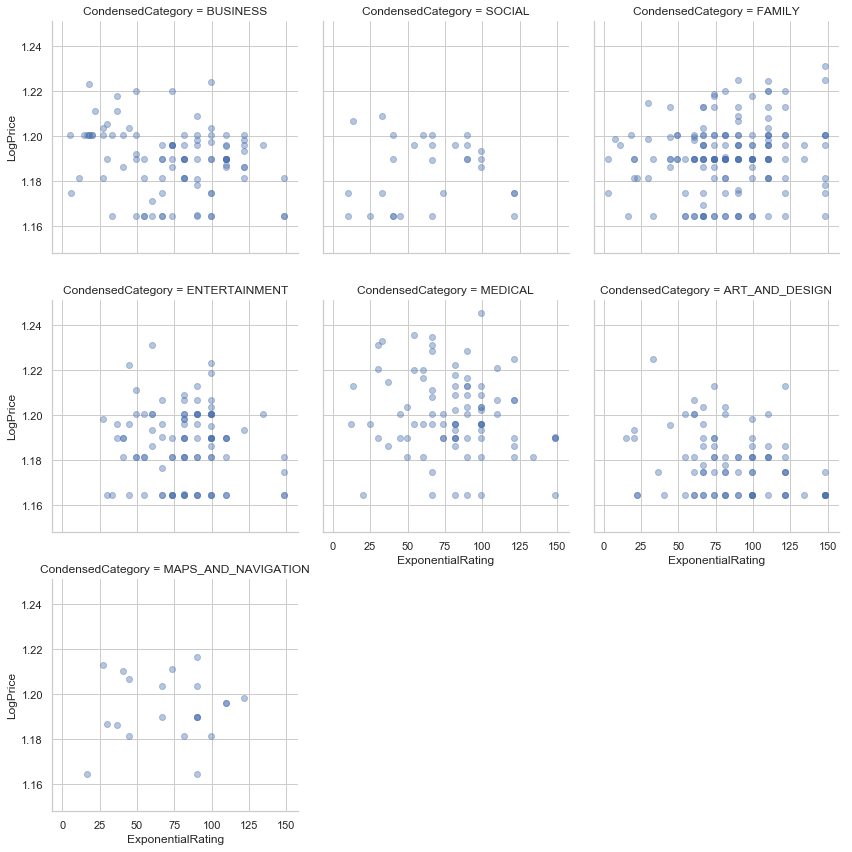

In [216]:
# Strongest Correlation is ART_AND_DESIGN at -.29
g = sns.FacetGrid(priced_data, col='CondensedCategory', col_wrap=3, height=4)
g = g.map(plt.scatter, 'ExponentialRating', 'LogPrice', alpha = .4)
for rating in sorted(priced_data.CondensedCategory.unique()):
    print(rating, ':\t ', np.corrcoef(priced_data.ExponentialRating[priced_data.CondensedCategory == rating], priced_data.LogPrice[priced_data.CondensedCategory == rating])[0][1])

interval (22.0, 33.0]
1 :	  -0.14842390080725432
2 :	  0.188953205816373
3 :	  0.09317755589474264
4 :	  0.4092699204138575
5 :	  -0.1930437207940441
6 :	  0.07760946170738699
7 :	  -0.1402636351507027
8 :	  -0.8800797138655169
9 :	  -0.18763212461075007


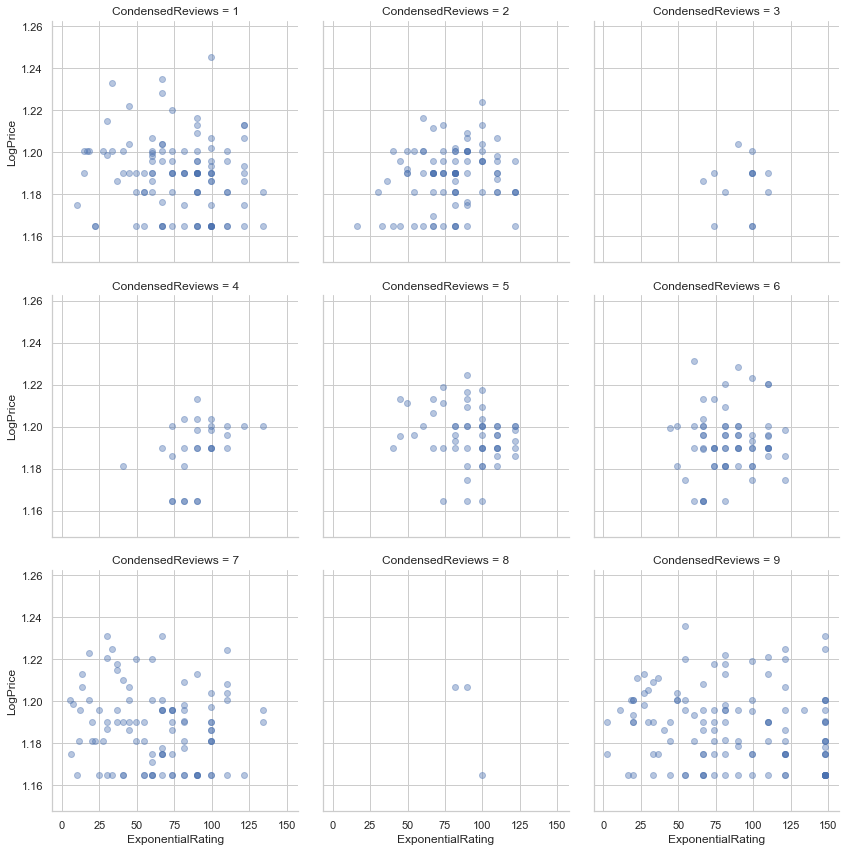

In [217]:
g = sns.FacetGrid(priced_data, col='CondensedReviews', col_wrap=3, height=4)
g = g.map(plt.scatter, 'ExponentialRating', 'LogPrice', alpha = .4)
# Strongest Correlation at the 4th interval:
print('interval', reviews_ranges[4])
for rating in sorted(priced_data.CondensedReviews.unique()):
    print(rating, ':\t ', np.corrcoef(priced_data.ExponentialRating[priced_data.CondensedReviews == rating], priced_data.LogPrice[priced_data.CondensedReviews== rating])[0][1])

interval (22.0, 33.0]
1 :	  -0.09666503405517461
2 :	  -0.07227173832076296
3 :	  -0.050072145453399615
4 :	  -0.3836786710346509
5 :	  0.22379805611624684
6 :	  0.2920301255356423
7 :	  1.0
8 :	  -0.901486542893023


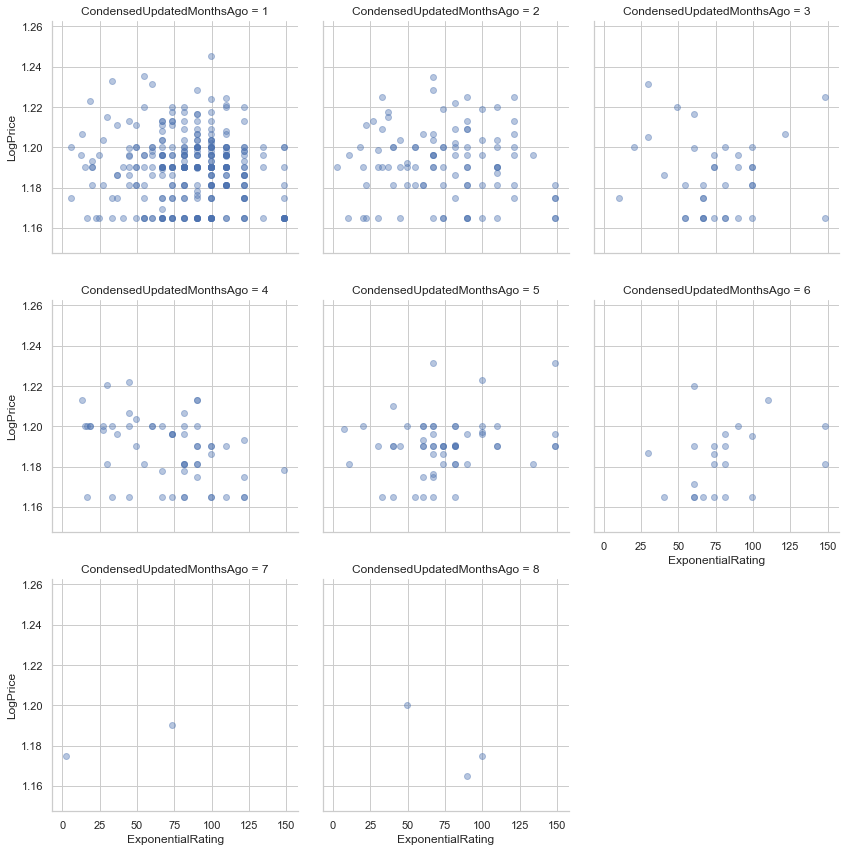

In [218]:
g = sns.FacetGrid(priced_data, col='CondensedUpdatedMonthsAgo', col_wrap=3, height=4)
g = g.map(plt.scatter, 'ExponentialRating', 'LogPrice', alpha = .4)
# Strongest Correlation at the 4th interval:
print('interval', reviews_ranges[4])
for rating in sorted(priced_data.CondensedUpdatedMonthsAgo.unique()):
    print(rating, ':\t ', np.corrcoef(priced_data.ExponentialRating[priced_data.CondensedUpdatedMonthsAgo == rating], priced_data.LogPrice[priced_data.CondensedUpdatedMonthsAgo == rating])[0][1])

In [273]:
old_ratings_array = [2,2,3,3,4,5,5,100,2,3]
new_ratings_array = [2,2,3,3,4,5,4,5]
n1 = len(old_ratings_array)
n2 = len(new_ratings_array)
mean1 = stats.mean(old_ratings_array)
mean2 = stats.mean(new_ratings_array)
std1 = stats.stdev(old_ratings_array)
std2 = stats.stdev(new_ratings_array)
df = n1 + n2 - 2
t = (mean1 - mean2)/(((std1**2/n1) + (std2**2/n2))**.5)
p = 1 - sts.t.cdf(t, df=df)
p

0.17331144213561278

In [274]:
t

0.969709558808807

In [275]:
sts.ttest_ind(old_ratings_array, new_ratings_array)

Ttest_indResult(statistic=0.8622736295712942, pvalue=0.40127654703618576)

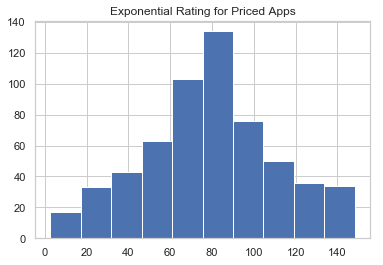

In [267]:
plt.hist(priced_data.ExponentialRating)
plt.title('Exponential Rating for Priced Apps')
plt.show()

In [266]:
sts.normaltest(priced_data.ExponentialRating)
# Tests the null hypothesis that this sample comes from a normal distribution. High p-values mean we cannot
# reject the null hypothesis and can guardedly work under the assumption that this is data comes 
# from a normal distribution.

NormaltestResult(statistic=1.3724099024430614, pvalue=0.5034831912361784)